In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [3]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 87.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.3:
      Successfully uninstalled tensorboard-2.12.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.12.0
    Uninstalling tensorflow-2.12.0:
     

In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

2023-10-18 11:40:19.283268: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-18 11:40:19.283337: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-18 11:40:19.283377: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import gdown

url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'Lip_reading_data.zip'

gdown.download(url, output, quiet=False)
gdown.extractall('Lip_reading_data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=5e6aa91e-3571-40ae-8ebd-3dadf8056cb6
To: /kaggle/working/Lip_reading_data.zip
100%|██████████| 423M/423M [00:04<00:00, 94.9MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [6]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [7]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [8]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [9]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [10]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [11]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [12]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [13]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [14]:
test_path = './data/s1/bbal6n.mpg'

In [15]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [16]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [17]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.460374  ],
         [ 1.460374  ],
         [ 1.4209044 ],
         ...,
         [ 0.15787826],
         [ 0.19734783],
         [ 0.07893913]],

        [[ 1.460374  ],
         [ 1.460374  ],
         [ 1.4209044 ],
         ...,
         [ 0.15787826],
         [ 0.07893913],
         [ 0.03946957]],

        [[ 1.4209044 ],
         [ 1.4209044 ],
         [ 1.3814349 ],
         ...,
         [ 0.07893913],
         [ 0.07893913],
         [ 0.07893913]],

        ...,

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.946331  ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.906861  ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.9472696 ],
         [ 0.9472696 ],
         [ 0.9472696 ],
         ...,
         [ 9.906861  ],
         [ 9.86739

In [18]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

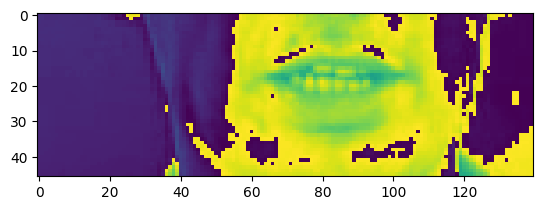

In [19]:
plt.imshow(frames[41])

In [20]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [21]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [22]:
def mappable_function(path:str) ->List[str]:
  result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
  return result

In [23]:
from matplotlib import pyplot as plt

In [24]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [25]:
len(train)

450

In [26]:
len(test)

50

In [27]:
frames, alignments = data.as_numpy_iterator().next()

In [28]:
len(frames)

2

In [29]:
sample = data.as_numpy_iterator()

In [30]:
val = sample.next(); val[0]

array([[[[[ 1.5254651 ],
          [ 1.5254651 ],
          [ 1.6017385 ],
          ...,
          [ 9.610431  ],
          [ 0.22881977],
          [ 0.26695642]],

         [[ 1.5254651 ],
          [ 1.5254651 ],
          [ 1.6017385 ],
          ...,
          [ 9.686704  ],
          [ 9.72484   ],
          [ 0.11440989]],

         [[ 1.3729186 ],
          [ 1.3729186 ],
          [ 1.3729186 ],
          ...,
          [ 0.11440989],
          [ 0.30509302],
          [ 0.30509302]],

         ...,

         [[ 0.99155235],
          [ 0.99155235],
          [ 0.99155235],
          ...,
          [ 0.07627326],
          [ 0.03813663],
          [ 0.03813663]],

         [[ 0.99155235],
          [ 0.99155235],
          [ 0.99155235],
          ...,
          [ 0.07627326],
          [ 0.03813663],
          [ 0.03813663]],

         [[ 0.99155235],
          [ 0.99155235],
          [ 0.99155235],
          ...,
          [ 0.07627326],
          [ 0.03813663],
          

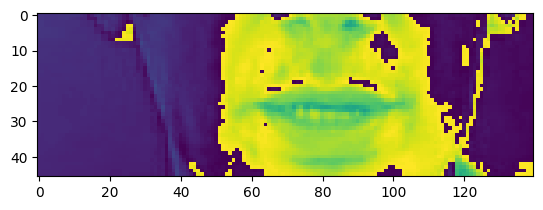

In [31]:
plt.imshow(val[0][0][35])

In [32]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by k six please'>

In [33]:
if np.isnan(val[1][1]).any() or np.isinf(val[1][1]).any():
    print("Input data contains NaN or infinite values.")
else:
    print("Not nan")

Not nan


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import accuracy_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [35]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [36]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))


In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [38]:
yhat = model.predict(val[0])

1/1 [==============================] - 3s 3s/step


In [39]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'33mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm'>

In [40]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'33mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm'>

In [41]:
model.input_shape

(None, 75, 46, 140, 1)

In [42]:
model.output_shape

(None, 75, 41)

In [43]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [44]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [45]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [46]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [47]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [48]:
schedule_callback = LearningRateScheduler(scheduler)

In [49]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
161/450 [=========>....................] - ETA: 3:08 - loss: 102.3511

[mpeg1video @ 0x7a385c2b3ec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a385c2b3ec0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 85.8052

[mpeg1video @ 0x7a3733382800] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3733382800] Warning MVs not available
[mpeg1video @ 0x7a372c0f1bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a372c0f1bc0] Warning MVs not available


1/1 [==============================] - 2s 2s/step
Original: place blue at v three soon
Prediction: le e e e e n
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green in l six please
Prediction: le e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 683s 1s/step - loss: 85.8052 - val_loss: 69.6703 - lr: 1.0000e-04
Epoch 2/100
400/450 [=========================>....] - ETA: 32s - loss: 70.6937

[mpeg1video @ 0x7a38747fab00] ac-tex damaged at 22 17
[mpeg1video @ 0x7a38747fab00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 70.5252

[mpeg1video @ 0x7a37280b4c80] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37280b4c80] Warning MVs not available


1/1 [==============================] - 0s 123ms/step
Original: place blue by j one again
Prediction: la e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white by p zero please
Prediction: la e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 494s 1s/step - loss: 70.5252 - val_loss: 63.8951 - lr: 1.0000e-04
Epoch 3/100
356/450 [======================>.......] - ETA: 1:01 - loss: 67.2762

[mpeg1video @ 0x7a387c0906c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a387c0906c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 66.9276

[mpeg1video @ 0x7a37330a45c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37330a45c0] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: set white by v three soon
Prediction: la e e t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white at n zero please
Prediction: la e e t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 496s 1s/step - loss: 66.9276 - val_loss: 62.1847 - lr: 1.0000e-04
Epoch 4/100
 74/450 [===>..........................] - ETA: 4:07 - loss: 64.5622

[mpeg1video @ 0x7a38840e78c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a38840e78c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 63.9460

[mpeg1video @ 0x7a37b858ba00] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37b858ba00] Warning MVs not available


1/1 [==============================] - 0s 112ms/step
Original: place red with j eight now
Prediction: la e t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white by h one again
Prediction: la re t e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 494s 1s/step - loss: 63.9460 - val_loss: 59.9847 - lr: 1.0000e-04
Epoch 5/100
248/450 [===============>..............] - ETA: 2:12 - loss: 62.3009

[mpeg1video @ 0x562571834f80] ac-tex damaged at 22 17
[mpeg1video @ 0x562571834f80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 61.8707

[mpeg1video @ 0x7a385c0a5c40] ac-tex damaged at 22 17
[mpeg1video @ 0x7a385c0a5c40] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Original: lay blue with r two now
Prediction: la re t e oa
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red with t seven again
Prediction: la re t e oa
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 493s 1s/step - loss: 61.8707 - val_loss: 57.7002 - lr: 1.0000e-04
Epoch 6/100
 36/450 [=>............................] - ETA: 4:32 - loss: 60.3372

[mpeg1video @ 0x7a3733a14980] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3733a14980] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 60.4521

[mpeg1video @ 0x7a38747bd640] ac-tex damaged at 22 17
[mpeg1video @ 0x7a38747bd640] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Original: lay white with f six now
Prediction: la re t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue at s two please
Prediction: la re e e an
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 494s 1s/step - loss: 60.4521 - val_loss: 56.3886 - lr: 1.0000e-04
Epoch 7/100
 25/450 [>.............................] - ETA: 4:37 - loss: 59.8042

[mpeg1video @ 0x7a37b0006540] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37b0006540] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 58.7452

[mpeg1video @ 0x7a3880034340] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3880034340] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: place blue in u nine soon
Prediction: la re t o o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue in f one again
Prediction: la re t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 493s 1s/step - loss: 58.7452 - val_loss: 54.6540 - lr: 1.0000e-04
Epoch 8/100
  3/450 [..............................] - ETA: 4:49 - loss: 56.5418

[mpeg1video @ 0x7a385c08df00] ac-tex damaged at 22 17
[mpeg1video @ 0x7a385c08df00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 56.6164

[mpeg1video @ 0x7a38880af300] ac-tex damaged at 22 17
[mpeg1video @ 0x7a38880af300] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Original: set white by v four please
Prediction: la re t e e an
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green in n two please
Prediction: la re t e e ae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 493s 1s/step - loss: 56.6164 - val_loss: 50.9391 - lr: 1.0000e-04
Epoch 9/100
340/450 [=====================>........] - ETA: 1:12 - loss: 53.1549

[mpeg1video @ 0x7a386c144780] ac-tex damaged at 22 17
[mpeg1video @ 0x7a386c144780] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 52.9109

[mpeg1video @ 0x5625715649c0] ac-tex damaged at 22 17
[mpeg1video @ 0x5625715649c0] Warning MVs not available


1/1 [==============================] - 0s 127ms/step
Original: bin green with h eight now
Prediction: la re i n o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red at v eight now
Prediction: la re t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 494s 1s/step - loss: 52.9109 - val_loss: 49.9080 - lr: 1.0000e-04
Epoch 10/100
265/450 [================>.............] - ETA: 2:00 - loss: 51.8006

[mpeg1video @ 0x7a388005d700] ac-tex damaged at 22 17
[mpeg1video @ 0x7a388005d700] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 51.0220

[mpeg1video @ 0x7a372c113700] ac-tex damaged at 22 17
[mpeg1video @ 0x7a372c113700] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Original: set blue by u two please
Prediction: la re t e lae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red in f seven again
Prediction: la re i e an
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 494s 1s/step - loss: 51.0220 - val_loss: 46.4883 - lr: 1.0000e-04
Epoch 11/100
224/450 [=============>................] - ETA: 2:28 - loss: 49.4501

[mpeg1video @ 0x7a387c05bc40] ac-tex damaged at 22 17
[mpeg1video @ 0x7a387c05bc40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 49.3379

[mpeg1video @ 0x7a3733a82800] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3733a82800] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: bin white at a two please
Prediction: la re t e lae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green at y two please
Prediction: la ble t e lae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 494s 1s/step - loss: 49.3379 - val_loss: 45.4659 - lr: 1.0000e-04
Epoch 12/100
239/450 [==============>...............] - ETA: 2:18 - loss: 47.3356

[mpeg1video @ 0x7a3884106a80] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3884106a80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 47.0128

[mpeg1video @ 0x7a37b8410880] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37b8410880] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: place white at d four please
Prediction: la re t e plae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green with a one again
Prediction: la re it e lae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 495s 1s/step - loss: 47.0128 - val_loss: 42.5335 - lr: 1.0000e-04
Epoch 13/100
450/450 [==============================] - ETA: 0s - loss: 44.6416

[mpeg1video @ 0x7a385c09ef80] ac-tex damaged at 22 17
[mpeg1video @ 0x7a385c09ef80] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: set blue in t five again
Prediction: pla blue b ie ae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red by p nine soon
Prediction: la ble b e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 495s 1s/step - loss: 44.6416 - val_loss: 38.7257 - lr: 1.0000e-04
Epoch 14/100
135/450 [========>.....................] - ETA: 3:27 - loss: 42.6549

[mpeg1video @ 0x7a37280ae600] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37280ae600] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 41.9658

[mpeg1video @ 0x7a38747b2200] ac-tex damaged at 22 17
[mpeg1video @ 0x7a38747b2200] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: set white with i nine soon
Prediction: set re it ie on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue with h eight please
Prediction: pla blue bt oe plae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 495s 1s/step - loss: 41.9658 - val_loss: 38.3660 - lr: 1.0000e-04
Epoch 15/100
243/450 [===============>..............] - ETA: 2:17 - loss: 40.1693

[mpeg1video @ 0x7a37b0046f00] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37b0046f00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 39.7068

[mpeg1video @ 0x7a38800a6d00] ac-tex damaged at 22 17
[mpeg1video @ 0x7a38800a6d00] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Original: place green at q nine again
Prediction: la gre it ie again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red in a six now
Prediction: set re i i ow
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 497s 1s/step - loss: 39.7068 - val_loss: 35.3678 - lr: 1.0000e-04
Epoch 16/100
450/450 [==============================] - ETA: 0s - loss: 37.6689

[mpeg1video @ 0x7a388803c1c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a388803c1c0] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: set red by b seven again
Prediction: ley re by ie again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red at u five again
Prediction: sit re it ie again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 495s 1s/step - loss: 37.6689 - val_loss: 32.1607 - lr: 1.0000e-04
Epoch 17/100
316/450 [====================>.........] - ETA: 1:28 - loss: 35.5980

[mpeg1video @ 0x7a386c018f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7a386c018f80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 35.6078

[mpeg1video @ 0x7a388c0b9dc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a388c0b9dc0] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Original: bin white by n three soon
Prediction: sit re by e son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red in y zero now
Prediction: ley red it o ow
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 496s 1s/step - loss: 35.6078 - val_loss: 31.1558 - lr: 1.0000e-04
Epoch 18/100
288/450 [==================>...........] - ETA: 1:46 - loss: 33.6190

[mpeg1video @ 0x7a38747f39c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a38747f39c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 33.5133

[mpeg1video @ 0x7a372c08df40] ac-tex damaged at 22 17
[mpeg1video @ 0x7a372c08df40] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Original: lay green in f three again
Prediction: lay re it ie again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue in r seven soon
Prediction: lit blue it e son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 493s 1s/step - loss: 33.5133 - val_loss: 28.0857 - lr: 1.0000e-04
Epoch 19/100
342/450 [=====================>........] - ETA: 1:10 - loss: 31.4605

[mpeg1video @ 0x7a388805a740] ac-tex damaged at 22 17
[mpeg1video @ 0x7a388805a740] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 31.4222

[mpeg1video @ 0x7a32a3e14240] ac-tex damaged at 22 17
[mpeg1video @ 0x7a32a3e14240] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: lay white at z zero now
Prediction: lat hie at in now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white at b six now
Prediction: sit white it i now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 494s 1s/step - loss: 31.4222 - val_loss: 26.4272 - lr: 1.0000e-04
Epoch 20/100
124/450 [=======>......................] - ETA: 3:33 - loss: 29.8309

[mpeg1video @ 0x7a388405d500] ac-tex damaged at 22 17
[mpeg1video @ 0x7a388405d500] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 29.2721

[mpeg1video @ 0x7a37b8415bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37b8415bc0] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Original: bin red with t five soon
Prediction: bin re with ie son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red by b six please
Prediction: sit wre by ie please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 493s 1s/step - loss: 29.2721 - val_loss: 23.9638 - lr: 1.0000e-04
Epoch 21/100
339/450 [=====================>........] - ETA: 1:12 - loss: 27.5946

[mpeg1video @ 0x7a37285163c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37285163c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 27.3610

[mpeg1video @ 0x7a3870091400] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3870091400] Warning MVs not available


1/1 [==============================] - 0s 119ms/step
Original: place blue in b nine again
Prediction: place blue iy ne again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red at j two please
Prediction: place re it o pleas
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 492s 1s/step - loss: 27.3610 - val_loss: 21.8387 - lr: 1.0000e-04
Epoch 22/100
 36/450 [=>............................] - ETA: 4:36 - loss: 25.7479

[mpeg1video @ 0x7a32a3957000] ac-tex damaged at 22 17
[mpeg1video @ 0x7a32a3957000] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 25.3307

[mpeg1video @ 0x7a387485fac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a387485fac0] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Original: lay blue by y four please
Prediction: la blue by ou please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue in t four please
Prediction: set blue it ou please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 495s 1s/step - loss: 25.3307 - val_loss: 20.1004 - lr: 1.0000e-04
Epoch 23/100
431/450 [===========================>..] - ETA: 12s - loss: 23.4797

[mpeg1video @ 0x7a37b8591a00] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37b8591a00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 23.4701

[mpeg1video @ 0x7a387c0c2840] ac-tex damaged at 22 17
[mpeg1video @ 0x7a387c0c2840] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: place red with x eight please
Prediction: place red with tih please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red with a three soon
Prediction: bin red with hre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 492s 1s/step - loss: 23.4701 - val_loss: 17.4899 - lr: 1.0000e-04
Epoch 24/100
212/450 [=============>................] - ETA: 2:35 - loss: 21.7887

[mpeg1video @ 0x7a385c024a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7a385c024a40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 21.8046

[mpeg1video @ 0x7a38841f0600] ac-tex damaged at 22 17
[mpeg1video @ 0x7a38841f0600] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: bin red in f five soon
Prediction: bin ren at five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white by t seven soon
Prediction: bin white by ene son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 491s 1s/step - loss: 21.8046 - val_loss: 16.7289 - lr: 1.0000e-04
Epoch 25/100
266/450 [================>.............] - ETA: 2:00 - loss: 20.4255

[mpeg1video @ 0x7a386c10ebc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a386c10ebc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 20.1080

[mpeg1video @ 0x56256ea11940] ac-tex damaged at 22 17
[mpeg1video @ 0x56256ea11940] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: set green with d one soon
Prediction: set gren ith oe son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white in j four please
Prediction: place white at fou please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 492s 1s/step - loss: 20.1080 - val_loss: 15.4573 - lr: 1.0000e-04
Epoch 26/100
365/450 [=======================>......] - ETA: 55s - loss: 18.5739

[mpeg1video @ 0x7a3880052500] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3880052500] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 18.5467

[mpeg1video @ 0x7a3728010cc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3728010cc0] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Original: bin green by h four now
Prediction: bin gren by fo now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue at t nine again
Prediction: set blue at nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 494s 1s/step - loss: 18.5467 - val_loss: 14.2737 - lr: 1.0000e-04
Epoch 27/100
160/450 [=========>....................] - ETA: 3:10 - loss: 17.5667

[mpeg1video @ 0x7a3884058440] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3884058440] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 17.2082

[mpeg1video @ 0x7a37b0059640] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37b0059640] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: place blue by i nine soon
Prediction: place blue by nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue with p nine again
Prediction: place blue with nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 495s 1s/step - loss: 17.2082 - val_loss: 12.1954 - lr: 1.0000e-04
Epoch 28/100
176/450 [==========>...................] - ETA: 2:59 - loss: 15.7938

[mpeg1video @ 0x7a372c07cb00] ac-tex damaged at 22 17
[mpeg1video @ 0x7a372c07cb00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 15.8908

[mpeg1video @ 0x7a38700a4f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7a38700a4f80] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Original: place blue in i zero now
Prediction: place blue in zr now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue by k six please
Prediction: lay blue by six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 493s 1s/step - loss: 15.8908 - val_loss: 11.4067 - lr: 1.0000e-04
Epoch 29/100
 12/450 [..............................] - ETA: 4:47 - loss: 14.9267

[mpeg1video @ 0x7a3733d16840] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3733d16840] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 15.0699

[mpeg1video @ 0x7a38747bb480] ac-tex damaged at 22 17
[mpeg1video @ 0x7a38747bb480] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: set blue with b four please
Prediction: set blue wit fou please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green in l five soon
Prediction: lay gren in five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 493s 1s/step - loss: 15.0699 - val_loss: 11.0255 - lr: 1.0000e-04
Epoch 30/100
434/450 [===========================>..] - ETA: 10s - loss: 14.1178

[mpeg1video @ 0x7a37b0017e40] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37b0017e40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 14.0980

[mpeg1video @ 0x7a387c0c9c40] ac-tex damaged at 22 17
[mpeg1video @ 0x7a387c0c9c40] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: bin blue with m five soon
Prediction: bin blue with five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green by s six now
Prediction: lay gren by six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 492s 1s/step - loss: 14.0980 - val_loss: 9.9140 - lr: 1.0000e-04
Epoch 31/100
 30/450 [=>............................] - ETA: 4:34 - loss: 13.2614

[mpeg1video @ 0x7a37b83ee140] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37b83ee140] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 13.1361

[mpeg1video @ 0x7a388c0af6c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a388c0af6c0] Warning MVs not available


1/1 [==============================] - 0s 129ms/step
Original: lay green in r eight now
Prediction: lay gren in eght now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green with m six now
Prediction: lay gren with six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 492s 1s/step - loss: 13.1361 - val_loss: 8.9840 - lr: 9.0484e-05
Epoch 32/100
277/450 [=================>............] - ETA: 1:53 - loss: 12.1593

[mpeg1video @ 0x7a388006f000] ac-tex damaged at 22 17
[mpeg1video @ 0x7a388006f000] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 12.1070

[mpeg1video @ 0x7a372801cac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a372801cac0] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: bin blue at z six please
Prediction: bin blue at six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green with g two now
Prediction: lay gren with two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 493s 1s/step - loss: 12.1070 - val_loss: 8.6897 - lr: 8.1873e-05
Epoch 33/100
401/450 [=========================>....] - ETA: 32s - loss: 11.4473

[mpeg1video @ 0x7a387c036640] ac-tex damaged at 22 17
[mpeg1video @ 0x7a387c036640] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 11.4136

[mpeg1video @ 0x7a3733666980] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3733666980] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: lay green in f zero now
Prediction: lay gren in zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green in v three again
Prediction: set gren in thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 493s 1s/step - loss: 11.4136 - val_loss: 7.8165 - lr: 7.4082e-05
Epoch 34/100
425/450 [===========================>..] - ETA: 16s - loss: 10.6934

[mpeg1video @ 0x7a388c0ba500] ac-tex damaged at 22 17
[mpeg1video @ 0x7a388c0ba500] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 10.6638

[mpeg1video @ 0x7a37b00c1980] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37b00c1980] Warning MVs not available


1/1 [==============================] - 0s 122ms/step
Original: lay green at f four now
Prediction: lay gren at for now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue at f five again
Prediction: bin blue at five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 491s 1s/step - loss: 10.6638 - val_loss: 6.9629 - lr: 6.7032e-05
Epoch 35/100
338/450 [=====================>........] - ETA: 1:13 - loss: 9.9340

[mpeg1video @ 0x562571e7af80] ac-tex damaged at 22 17
[mpeg1video @ 0x562571e7af80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 9.9212

[mpeg1video @ 0x7a385c06a380] ac-tex damaged at 22 17
[mpeg1video @ 0x7a385c06a380] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Original: lay red by r seven again
Prediction: lay red by seve again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red by z zero please
Prediction: lay red by z zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 492s 1s/step - loss: 9.9212 - val_loss: 6.6974 - lr: 6.0653e-05
Epoch 36/100
200/450 [============>.................] - ETA: 2:45 - loss: 9.4103

[mpeg1video @ 0x7a37280a8140] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37280a8140] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 9.4505

[mpeg1video @ 0x7a386c12bf80] ac-tex damaged at 22 17
[mpeg1video @ 0x7a386c12bf80] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: bin green with u seven soon
Prediction: bin gren with seven son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green in o nine again
Prediction: set gren in nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 493s 1s/step - loss: 9.4505 - val_loss: 6.1132 - lr: 5.4881e-05
Epoch 37/100
450/450 [==============================] - ETA: 0s - loss: 8.8941

[mpeg1video @ 0x7a387c0b0700] ac-tex damaged at 22 17
[mpeg1video @ 0x7a387c0b0700] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: bin red with g six now
Prediction: bin red with six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green with o four please
Prediction: bin gren with for please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 493s 1s/step - loss: 8.8941 - val_loss: 5.7173 - lr: 4.9659e-05
Epoch 38/100
111/450 [======>.......................] - ETA: 3:42 - loss: 8.6916

[mpeg1video @ 0x7a37b8499280] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37b8499280] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 8.6397

[mpeg1video @ 0x7a3888062180] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3888062180] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: place red at c eight please
Prediction: place red at eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red sp with z five again
Prediction: lay red with five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 492s 1s/step - loss: 8.6397 - val_loss: 5.3809 - lr: 4.4933e-05
Epoch 39/100
207/450 [============>.................] - ETA: 2:38 - loss: 8.4037

[mpeg1video @ 0x7a3870034780] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3870034780] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 8.2671

[mpeg1video @ 0x7a388c0b2cc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a388c0b2cc0] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Original: lay red with f two please
Prediction: lay red with two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green in j nine soon
Prediction: place gren in nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 492s 1s/step - loss: 8.2671 - val_loss: 4.9908 - lr: 4.0657e-05
Epoch 40/100
322/450 [====================>.........] - ETA: 1:23 - loss: 7.8434

[mpeg1video @ 0x7a38747fb700] ac-tex damaged at 22 17
[mpeg1video @ 0x7a38747fb700] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.7800

[mpeg1video @ 0x7a372c027440] ac-tex damaged at 22 17
[mpeg1video @ 0x7a372c027440] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: lay green with m eight please
Prediction: lay gren with eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue with p eight please
Prediction: place blue with p eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 492s 1s/step - loss: 7.7800 - val_loss: 4.5568 - lr: 3.6788e-05
Epoch 41/100
308/450 [===================>..........] - ETA: 1:32 - loss: 7.4315

[mpeg1video @ 0x7a387c0dd240] ac-tex damaged at 22 17
[mpeg1video @ 0x7a387c0dd240] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.4354

[mpeg1video @ 0x7a32a3ad6480] ac-tex damaged at 22 17
[mpeg1video @ 0x7a32a3ad6480] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: place green at d nine soon
Prediction: place gren at nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white in y nine again
Prediction: lay white in nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 493s 1s/step - loss: 7.4354 - val_loss: 4.2733 - lr: 3.3287e-05
Epoch 42/100
182/450 [===========>..................] - ETA: 2:56 - loss: 7.0615

[mpeg1video @ 0x7a388c0c1800] ac-tex damaged at 22 17
[mpeg1video @ 0x7a388c0c1800] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.1535

[mpeg1video @ 0x7a37b844d140] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37b844d140] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Original: lay white in l one again
Prediction: lay white in l one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white with n nine again
Prediction: bin white with nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 494s 1s/step - loss: 7.1535 - val_loss: 4.2954 - lr: 3.0119e-05
Epoch 43/100
402/450 [=========================>....] - ETA: 31s - loss: 6.9966

[mpeg1video @ 0x7a372c06b600] ac-tex damaged at 22 17
[mpeg1video @ 0x7a372c06b600] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.9664

[mpeg1video @ 0x7a38701ed680] ac-tex damaged at 22 17
[mpeg1video @ 0x7a38701ed680] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Original: lay blue in d five again
Prediction: lay blue in d five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red with t four now
Prediction: bin red with t four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 493s 1s/step - loss: 6.9664 - val_loss: 3.7595 - lr: 2.7253e-05
Epoch 44/100
248/450 [===============>..............] - ETA: 2:13 - loss: 6.6232

[mpeg1video @ 0x7a37339c74c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37339c74c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.6034

[mpeg1video @ 0x7a38747d9780] ac-tex damaged at 22 17
[mpeg1video @ 0x7a38747d9780] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Original: place green by k eight please
Prediction: place gren by eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white in b two now
Prediction: set white in b two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 493s 1s/step - loss: 6.6034 - val_loss: 4.6009 - lr: 2.4660e-05
Epoch 45/100
305/450 [===================>..........] - ETA: 1:35 - loss: 6.4671

[mpeg1video @ 0x7a32a3e00b80] ac-tex damaged at 22 17
[mpeg1video @ 0x7a32a3e00b80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.4759

[mpeg1video @ 0x7a3880bb9fc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3880bb9fc0] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: set white at o five soon
Prediction: set white at five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red at c six now
Prediction: place red at c six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 494s 1s/step - loss: 6.4759 - val_loss: 3.7777 - lr: 2.2313e-05
Epoch 46/100
259/450 [================>.............] - ETA: 2:05 - loss: 6.2888

[mpeg1video @ 0x7a37b83fd980] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37b83fd980] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.3183

[mpeg1video @ 0x7a3889442d00] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3889442d00] Warning MVs not available


1/1 [==============================] - 0s 124ms/step
Original: lay white in l zero please
Prediction: lay white in l zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue in q one soon
Prediction: lay blue in one son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 492s 1s/step - loss: 6.3183 - val_loss: 3.4101 - lr: 2.0190e-05
Epoch 47/100
282/450 [=================>............] - ETA: 1:50 - loss: 6.2104

[mpeg1video @ 0x7a3870072780] ac-tex damaged at 22 17
[mpeg1video @ 0x7a3870072780] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.1615

[mpeg1video @ 0x562574835d40] ac-tex damaged at 22 17
[mpeg1video @ 0x562574835d40] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Original: lay red in k five again
Prediction: lay red in five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green with r seven again
Prediction: place gren with r seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 494s 1s/step - loss: 6.1615 - val_loss: 3.2497 - lr: 1.8268e-05
Epoch 48/100
 61/450 [===>..........................] - ETA: 4:14 - loss: 6.4297

[mpeg1video @ 0x7a388002e5c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7a388002e5c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.9339

[mpeg1video @ 0x7a372801af00] ac-tex damaged at 22 17
[mpeg1video @ 0x7a372801af00] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Original: place white with y five again
Prediction: place white with five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white at v one again
Prediction: set white at one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 495s 1s/step - loss: 5.9339 - val_loss: 3.3455 - lr: 1.6530e-05
Epoch 49/100
 84/450 [====>.........................] - ETA: 3:59 - loss: 5.9709

[mpeg1video @ 0x7a38880c3f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7a38880c3f80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.7200

[mpeg1video @ 0x7a32a3be3340] ac-tex damaged at 22 17
[mpeg1video @ 0x7a32a3be3340] Warning MVs not available


1/1 [==============================] - 0s 111ms/step
Original: bin white at g seven again
Prediction: bin white at seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green with u six now
Prediction: bin gren with six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 493s 1s/step - loss: 5.7200 - val_loss: 3.2091 - lr: 1.4957e-05
Epoch 50/100
121/450 [=======>......................] - ETA: 3:35 - loss: 5.7083

[mpeg1video @ 0x7a388c0e2d00] ac-tex damaged at 22 17
[mpeg1video @ 0x7a388c0e2d00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.7391

[mpeg1video @ 0x7a37b00da940] ac-tex damaged at 22 17
[mpeg1video @ 0x7a37b00da940] Warning MVs not available


1/1 [==============================] - 0s 111ms/step
Original: bin white by t eight sp please
Prediction: bin white by t eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red by o five again
Prediction: set red by five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 494s 1s/step - loss: 5.7391 - val_loss: 3.1096 - lr: 1.3534e-05
Epoch 51/100
 64/450 [===>..........................] - ETA: 4:15 - loss: 5.2413

In [ ]:
model.load_weights('models/checkpoint')